In [40]:
#download dataset at http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

import tools.image_gen_extended as T

In [2]:
# Setup multiprocessing pool
# Do this early, as once images are loaded into memory there will be Errno 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

In [3]:
class_to_ix = {}
ix_to_class = {}
with open('fit-or-not-ai/food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [ ]:
# Only split files if haven't already
if not os.path.isdir('./fit-or-not-ai/food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)
    
    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('fit-or-not-ai/food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('fit-or-not-ai/food-101/meta/test.txt')
    # print(train_dir_files)

    def ignore_train(d, filenames):
        subdir = d.split('\\')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('\\')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('fit-or-not-ai/food-101/images', 'fit-or-not-ai/food-101/test', ignore=ignore_train)
    copytree('fit-or-not-ai/food-101/images', 'fit-or-not-ai/food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

In [4]:
%%time
# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, current_index, batch_size, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        # print(i, class_ix, subdir)
        for img_index in range(current_index*batch_size, (current_index+1)*batch_size):
            img_arr = img.imread(join(root, subdir, imgs[img_index]))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                # print('Skipping bad image: ', subdir, imgs[img_index])
                invalid_count += 1
    # print(len(all_imgs), 'images loaded')
    # print(resize_count, 'images resized')
    # print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)

Wall time: 0 ns


In [5]:
X_test, y_test = load_images('fit-or-not-ai/food-101/test', 0, 50, min_side=299)

C:\Users\CristianCosmin\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


C:\Users\CristianCosmin\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
def schedule(epoch):
        if epoch < 15:
            return .01
        elif epoch < 28:
            return .002
        else:
            return .0004
   
n_classes = 101

K.clear_session()

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

lr_scheduler = LearningRateScheduler(schedule)
        
for i in range(125):
    X_test, y_test = load_images('food-101/test', i, 2, min_side=299)
    X_train, y_train = load_images('food-101/train', i, 6, min_side=299)
    print('X_train shape', X_train.shape)
    y_train_cat = to_categorical(y_train, n_classes)
    y_test_cat = to_categorical(y_test, n_classes)
    # this is the augmentation configuration for training
    train_datagen = T.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        zoom_range=[.8, 1],
        channel_shift_range=30,
        fill_mode='reflect')
    train_datagen.config['random_crop_size'] = (299, 299)
    train_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
    train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=10, seed=11, pool=pool)
    test_datagen = T.ImageDataGenerator()
    test_datagen.config['random_crop_size'] = (299, 299)
    test_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
    test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=10, seed=11, pool=pool)

    model.fit_generator(train_generator,
                        steps_per_epoch=X_train.shape[0],
                        epochs=2,
                        verbose=2,
                        callbacks=[lr_scheduler, csv_logger, checkpointer],
                        validation_data=test_generator,
                        validation_steps=X_test.shape[0])

In [6]:
%%time
#here we load the best model
model = load_model(filepath='./fit-or-not-ai/model4.01-2.23.hdf5') # 58.78

Wall time: 43 s


In [7]:
def center_crop(x, center_crop_size, **kwargs):
    centerw, centerh = x.shape[0]//2, x.shape[1]//2
    halfw, halfh = center_crop_size[0]//2, center_crop_size[1]//2
    return x[centerw-halfw:centerw+halfw+1,centerh-halfh:centerh+halfh+1, :]

In [8]:
def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    flipped_X = np.fliplr(img)
    crops = [
        img[:299,:299, :], # Upper Left
        img[:299, img.shape[1]-299:, :], # Upper Right
        img[img.shape[0]-299:, :299, :], # Lower Left
        img[img.shape[0]-299:, img.shape[1]-299:, :], # Lower Right
        center_crop(img, (299, 299)),
        
        flipped_X[:299,:299, :],
        flipped_X[:299, flipped_X.shape[1]-299:, :],
        flipped_X[flipped_X.shape[0]-299:, :299, :],
        flipped_X[flipped_X.shape[0]-299:, flipped_X.shape[1]-299:, :],
        center_crop(flipped_X, (299, 299))
    ]
    if preprocess:
        crops = [preprocess_input(x.astype('float32')) for x in crops]

    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])
    
    y_pred = model.predict(np.array(crops))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

    
ix = 101
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=False, debug=True)

Top-1 Predicted: [21 21  7  7  7 21 21  7  7  7]
Top-5 Predicted: [[32 34 44  7 21]
 [33 35  7 44 21]
 [35 33 34 21  7]
 [33 35 21 44  7]
 [32 34 44 21  7]
 [33 35  7 44 21]
 [32 34 44  7 21]
 [32 34 44 21  7]
 [31 84 44 21  7]
 [32 34 44 21  7]]
True Label: 2


(array([21, 21,  7,  7,  7, 21, 21,  7,  7,  7], dtype=int64),
 array([[32, 34, 44,  7, 21],
        [33, 35,  7, 44, 21],
        [35, 33, 34, 21,  7],
        [33, 35, 21, 44,  7],
        [32, 34, 44, 21,  7],
        [33, 35,  7, 44, 21],
        [32, 34, 44,  7, 21],
        [32, 34, 44, 21,  7],
        [31, 84, 44, 21,  7],
        [32, 34, 44, 21,  7]], dtype=int64))

In [9]:
%%time
preds_10_crop = {}
for ix in range(len(X_test)):
    if ix % 1000 == 0:
        print(ix)
    preds_10_crop[ix] = predict_10_crop(X_test[ix], ix)

0


1000


2000


3000


4000


5000


Wall time: 14min 3s


Text(0.5,1,'Number of unique predictions')

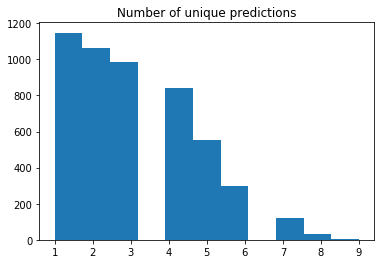

In [10]:
preds_uniq = {k: np.unique(v[0]) for k, v in preds_10_crop.items()}
preds_hist = np.array([len(x) for x in preds_uniq.values()])
plt.hist(preds_hist, bins=11)
plt.title('Number of unique predictions')

In [11]:
preds_top_1 = {k: collections.Counter(v[0]).most_common(1) for k, v in preds_10_crop.items()}
top_5_per_ix = {k: collections.Counter(preds_10_crop[k][1].reshape(-1)).most_common(5) for k, v in preds_10_crop.items()}
preds_top_5 = {k: [y[0] for y in v] for k, v, in top_5_per_ix.items()}


In [12]:
right_counter = 0
for i in range(50):
    guess, actual = preds_top_1[i][0][0], y_test[i]
    if guess == actual:
        right_counter += 1
print('Top-1 Accuracy, 10-Crop: {0:.2f}%'.format(right_counter/50 * 100))

Top-1 Accuracy, 10-Crop: 40.00%


In [13]:
top_5_counter = 0
for i in range(len(y_test)):
    guesses, actual = preds_top_5[i], y_test[i]
    if actual in guesses:
        top_5_counter += 1
print('Top-5 Accuracy, 10-Crop: {0:.2f}%'.format(top_5_counter / len(y_test) * 100))

Top-5 Accuracy, 10-Crop: 81.50%


In [14]:
y_pred = [x[0][0] for x in preds_top_1.values()]

<p>Failed to display Jupyter Widget of type <code>interactive</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

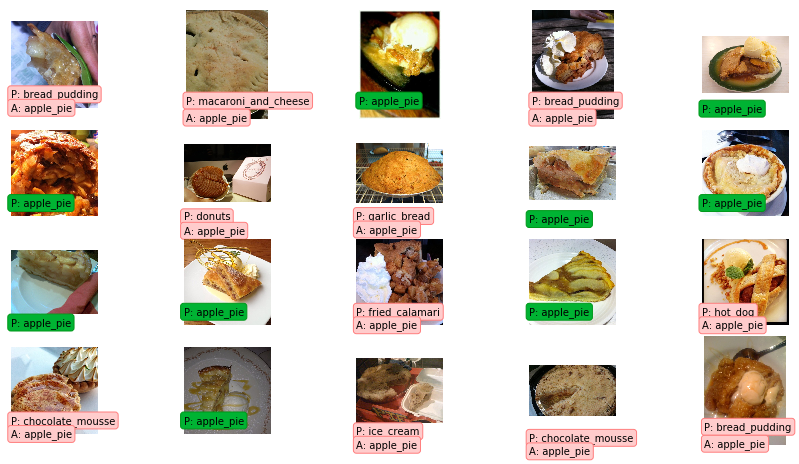

In [32]:
@interact(page=[0, int(len(X_test) / 20)])
def show_images_prediction(page=0):
    page_size = 20
    nrows = 4
    nrcols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=nrcols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[i + start_i])
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = ix_to_class[y_pred[i + start_i]]
        match = predicted == ix_to_class[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        ax.text(0, 400, 'P: ' + predicted, size=10, rotation=0, ha="left", va="top",
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
        if not match:
            ax.text(0, 480, 'A: ' + ix_to_class[y_test[start_i + i]], size=10, rotation=0, ha="left", va="top",
                    bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

In [41]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = [ix_to_class[i] for i in range(101)]

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()


Confusion matrix, without normalization
[[20  0  0 ...,  0  0  0]
 [ 0 32  0 ...,  0  0  0]
 [11  0 31 ...,  0  0  0]
 ..., 
 [ 2  0  0 ..., 34  0  0]
 [ 1  0  0 ...,  0 21  0]
 [ 3  0  0 ...,  0  0 34]]


Text(0.5,1,'Accuracy by Class histogram')

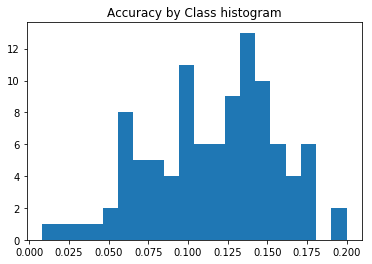

In [18]:
corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)
for (pred, actual) in zip(y_pred, y_test):
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

class_accuracies = {}
for ix in range(101):
    class_accuracies[ix] = corrects[ix]/250

plt.hist(list(class_accuracies.values()), bins=20)
plt.title('Accuracy by Class histogram')

In [19]:
sorted_class_accuracies = sorted(class_accuracies.items(), key=lambda x: -x[1])
[(ix_to_class[c[0]], c[1]) for c in sorted_class_accuracies]

[('edamame', 0.2),
 ('macarons', 0.192),
 ('hot_and_sour_soup', 0.18),
 ('miso_soup', 0.18),
 ('pho', 0.18),
 ('creme_brulee', 0.172),
 ('dumplings', 0.172),
 ('spaghetti_bolognese', 0.172),
 ('beignets', 0.164),
 ('french_fries', 0.164),
 ('oysters', 0.164),
 ('pad_thai', 0.164),
 ('caprese_salad', 0.16),
 ('onion_rings', 0.16),
 ('eggs_benedict', 0.156),
 ('guacamole', 0.156),
 ('lobster_bisque', 0.156),
 ('takoyaki', 0.156),
 ('red_velvet_cake', 0.152),
 ('fried_calamari', 0.148),
 ('pancakes', 0.148),
 ('sashimi', 0.148),
 ('sushi', 0.148),
 ('bibimbap', 0.144),
 ('deviled_eggs', 0.144),
 ('fried_rice', 0.144),
 ('mussels', 0.144),
 ('seaweed_salad', 0.144),
 ('churros', 0.14),
 ('french_toast', 0.14),
 ('spring_rolls', 0.14),
 ('beef_carpaccio', 0.136),
 ('croque_madame', 0.136),
 ('donuts', 0.136),
 ('escargots', 0.136),
 ('greek_salad', 0.136),
 ('macaroni_and_cheese', 0.136),
 ('poutine', 0.136),
 ('prime_rib', 0.136),
 ('tiramisu', 0.136),
 ('waffles', 0.136),
 ('ceviche', 0.1

In [ ]:
import urllib.request

@interact
def predict_remote_image(url='http://www.simplyrecipes.com/wp-content/uploads/2014/12/prime-rib-horiz-a-1600.jpg'):
    with urllib.request.urlopen(url) as f:
        pic = plt.imread(f, format='jpg')
        preds = predict_10_crop(np.array(pic), 0)[0]
        best_pred = collections.Counter(preds).most_common(1)[0][0]
        print(ix_to_class[best_pred])
        plt.imshow(pic)

In [45]:
with open('model.json', 'w') as f:
    f.write(model.to_json())